In [52]:
#import the library
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import seaborn as sns
import rpy2.rinterface_lib.callbacks
import logging
import os
from rpy2.robjects import pandas2ri
import anndata2ri
from adjustText import adjust_text
import importlib
import warnings
warnings.filterwarnings("ignore")
import glob
import pickle as pkl
from matplotlib.colors import LinearSegmentedColormap

In [53]:
from matplotlib.colors import LinearSegmentedColormap
values = [0,1]
colors = [(227, 227, 227), (255, 42, 18)]
norm = plt.Normalize(min(values), max(values))
my_cmap = LinearSegmentedColormap.from_list(
    '', [(norm(value), tuple(np.array(color) / 255)) for value, color in zip(values, colors)])

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from sklearn.metrics import auc
def compute_recovery_auc(expression_profile, target_genes):
    """
    Compute the AUC for recovery of target genes in a ranked gene expression profile.
    Target genes with 0 expression are not counted as recovered.
    """
    genes, values = zip(*expression_profile.items())
    ranks = rankdata([-v for v in values], method='average')
    ranked_genes = [gene for _, gene in sorted(zip(ranks, genes))]

    recovery_curve = []
    recovered = 0
    target_count = len(target_genes)

    for i, gene in enumerate(ranked_genes, start=1):
        # Only count recovery if the gene has non-zero expression
        if expression_profile[gene] != 0 and gene in target_genes.values:
            recovered += 1
        recovery_curve.append(recovered / target_count)

    x_vals = np.linspace(0, 1, len(recovery_curve))
    y_vals = np.array(recovery_curve)
    auc_value = auc(x_vals, y_vals)
    return auc_value, recovery_curve

In [56]:
wd = r'F:\gdT_aim2\NicheNet'
os.chdir(wd)

In [57]:
ligand_csv_files = glob.glob(os.path.join(wd, "withSCENIC\*.csv"))
celltype_names = [os.path.splitext(os.path.basename(npath))[0].replace('_ligand_activities','') for npath in ligand_csv_files]
ligand_to_report = pd.DataFrame(index = np.arange(0,30), columns=celltype_names)
for i, npath in enumerate(ligand_csv_files):
    target_genes_df = pd.read_csv(npath, sep=",")
    target_genes = target_genes_df[target_genes_df['auroc']>0.5]["test_ligand"].iloc[0:min(30, len(target_genes_df[target_genes_df['auroc']>0.5]["test_ligand"]))]
    ligand_to_report.iloc[:,i][0:min(30, len(target_genes_df[target_genes_df['auroc']>0.5]["test_ligand"]))] = target_genes.values
    
# ligand_to_report.to_csv('top30_ligand_to_report.csv')

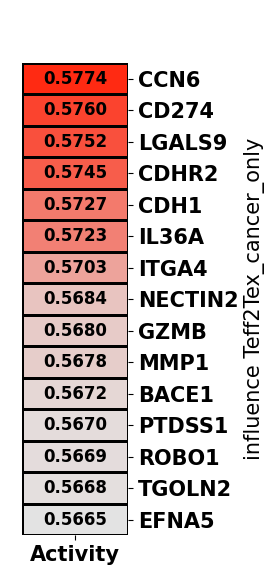

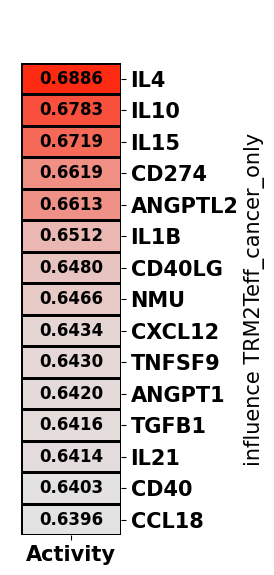

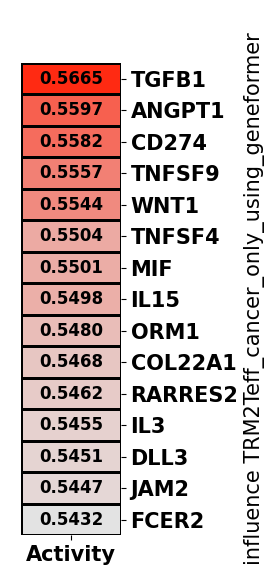

In [59]:
%matplotlib inline
plt.rcParams.update({'font.size': 15, 'font.weight': 'heavy','axes.linewidth':2})
#plt.rcParams.update(plt.rcParamsDefault)
kwargs = {'cmap': my_cmap}

for ii, npath in enumerate(ligand_csv_files):
    plot_df = pd.read_csv(npath, sep=",", index_col= "test_ligand")["auroc"]
    plot_df = plot_df[plot_df>0.5][0:min(30,plot_df.shape[0])]
    plot_df.index.name = 'influence ' +  celltype_names[ii]
    plot_df.name = 'Activity'
    clustergrid = sns.clustermap(plot_df[0:min(15,plot_df.shape[0])],figsize = (3,6),linewidths=2,
               linecolor = 'k',dendrogram_ratio = 0.1, colors_ratio = 0.5, cbar_pos= None,
               row_cluster = False,col_cluster = False,#cbar_kws={'label': 'NicheNet ligand activity (AUROC)','location':"left"},
               **kwargs)
    # for a in clustergrid.ax_col_dendrogram.collections:
    #     a.set_linewidth(2)
    #     clustergrid.ax_cbar.set_position([-10, 0, -0.3, 0.3])

    axs = clustergrid.fig.get_axes()
    for j in range(0,len(axs)): 
        axs[j].set_xlabel('')

    ax = clustergrid.ax_heatmap

    # Extract data values and annotate each cell
    for i in range(plot_df[0:15].shape[0]):  # Iterate over rows
        for j in range(1):  # Since there's only one column
            value = plot_df[0:15].iloc[i]  # Get value
            ax.text(j+0.5, i+0.5, f'{value:.4f}', ha='center', va='center', color='black', fontsize=12, fontweight='bold')



    # plt.savefig('vis/'+celltype_names[ii]+'ligand_vis.png',dpi = 300,bbox_inches='tight')

## Compare with and without SCENIC

{'BTN2A1', 'EPHA2', 'MR1', 'CD1C', 'EPCR', 'CD1A', 'BTNL3'}
                                1st quartile (S)  2nd quartile (S)  \
1st quartile (NS)                            153                35   
2nd quartile (NS)                             26               129   
3rd quartile (NS)                              9                26   
4th quartile (NS)                              1                 1   
only in prediction with SCENIC                 2                 0   

                                3rd quartile (S)  4th quartile (S)  
1st quartile (NS)                              1                 0  
2nd quartile (NS)                             33                 1  
3rd quartile (NS)                            134                20  
4th quartile (NS)                             19               166  
only in prediction with SCENIC                 4                 1  
                                1st quartile (S)  2nd quartile (S)  \
1st quartile (NS)                  

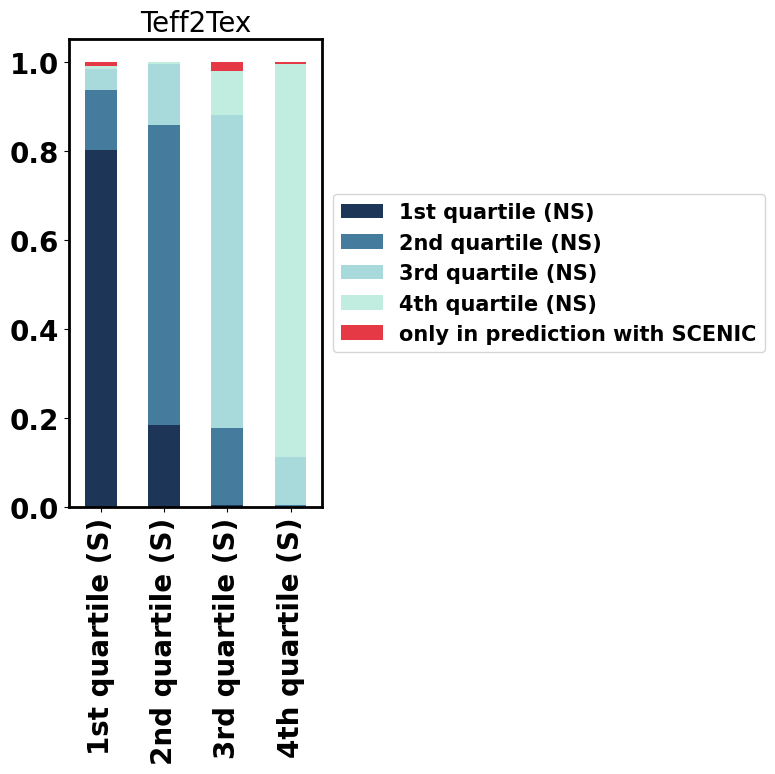

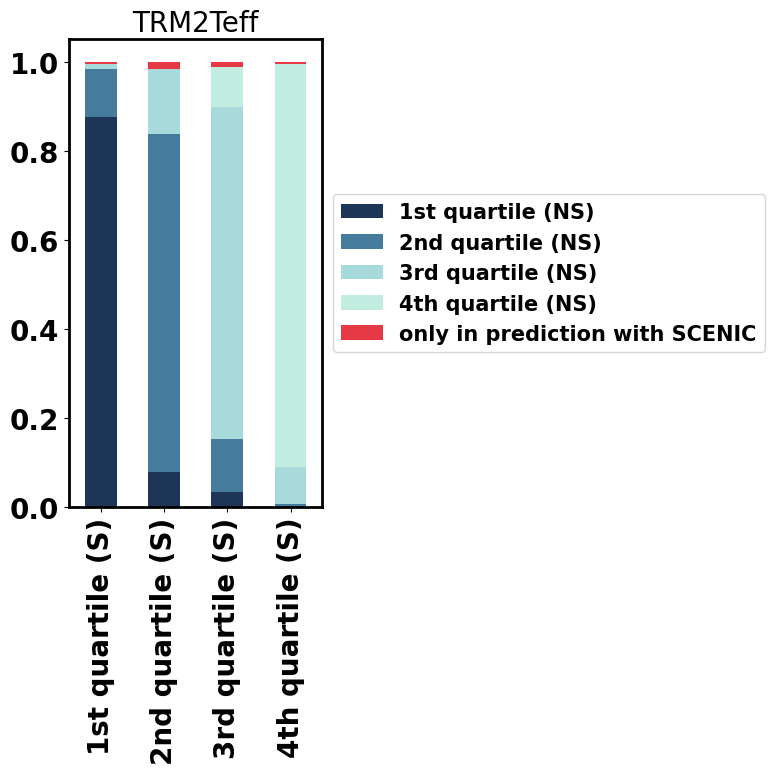

In [7]:
plt.rcParams.update({'font.size': 15, 'font.weight': 'heavy','axes.linewidth':2,'figure.figsize':[8,8]})

ligand_csv_files_withscn = glob.glob(os.path.join(wd, "withSCENIC\*.csv"))
celltype_names = [os.path.splitext(os.path.basename(npath))[0].replace('_ligand_activities','') for npath in ligand_csv_files_withscn]
for i, npath in enumerate(ligand_csv_files_withscn):
    target_genes_df_withscn = pd.read_csv(npath, sep=",")
    alt_path = npath.replace('withSCENIC','withoutSCENIC')
    target_genes_df_withoutscn = pd.read_csv(alt_path, sep=",")

    target_genes_withscn = target_genes_df_withscn[target_genes_df_withscn['auroc']>0.5]["test_ligand"]
    target_genes_withoutscn = target_genes_df_withoutscn[target_genes_df_withoutscn['auroc']>0.5]["test_ligand"]
    
    print(set(target_genes_withscn)-set(target_genes_withoutscn))

    percentile_df_withscn = pd.DataFrame(np.pad(np.array(target_genes_withscn), (0, 4-len(target_genes_withscn)%4),'constant', constant_values=np.nan).reshape((4, len(target_genes_withscn)//4+1)).T)
    percentile_df_withscn.columns  = ['1st quartile (S)','2nd quartile (S)','3rd quartile (S)','4th quartile (S)']
    # percentile_isinpct_df_withscn = pd.DataFrame(index = ['also in w//o SCENIC prediction', 'only in w// SCENIC prediction'], columns = percentile_df_withscn.columns)

    percentile_df_withoutscn = pd.DataFrame(np.pad(np.array(target_genes_withoutscn), (0, 4-len(target_genes_withoutscn)%4),'constant', constant_values=np.nan).reshape((4, len(target_genes_withoutscn)//4+1)).T)
    percentile_df_withoutscn.columns  = ['1st quartile (NS)','2nd quartile (NS)','3rd quartile (NS)','4th quartile (NS)']
    gene_to_quartile = {}
    for quartile in percentile_df_withoutscn.columns:
        # drop NaNs and get unique genes
        genes = percentile_df_withoutscn[quartile].dropna().unique()
        for g in genes:
            gene_to_quartile[g] = quartile

    # 2. define a small helper that maps a gene to its quartile (or “Not in withoutscn”)
    def lookup_quartile(g):
        if pd.isna(g):
            return np.nan
        return gene_to_quartile.get(g, 'only in prediction with SCENIC')

    # 3. apply it element‐wise to your “withscn” df
    membership_df = percentile_df_withscn.applymap(lookup_quartile)

    composition_counts = membership_df.apply(pd.Series.value_counts).fillna(0).astype(int)
    composition_counts.to_csv(celltype_names[i]+'compare with no SCENIC.csv')

    # proportions per column
    composition_props = membership_df.apply(lambda col: col.value_counts(normalize=True)).fillna(0)

    print(composition_counts)
    print(composition_props)

    composition_props.T.plot.bar(stacked=True,color = ["#1d3557","#457b9d","#a8dadc","#c0ede0","#e63946"],fontsize = 20).legend(loc='center left',bbox_to_anchor=(1.0, 0.5),fontsize = 15)

    plt.title(label = celltype_names[i].replace('_cancer_only',''), fontsize = 20)
    plt.tight_layout()
    plt.savefig('vis/'+celltype_names[i]+' compare with no SCENIC',dpi = 300)


FileNotFoundError: [Errno 2] No such file or directory: 'F:\\gdT_aim2\\NicheNet\\withoutSCENIC\\TRM2Teff_ligand_activities_cancer_only_using_geneformer.csv'

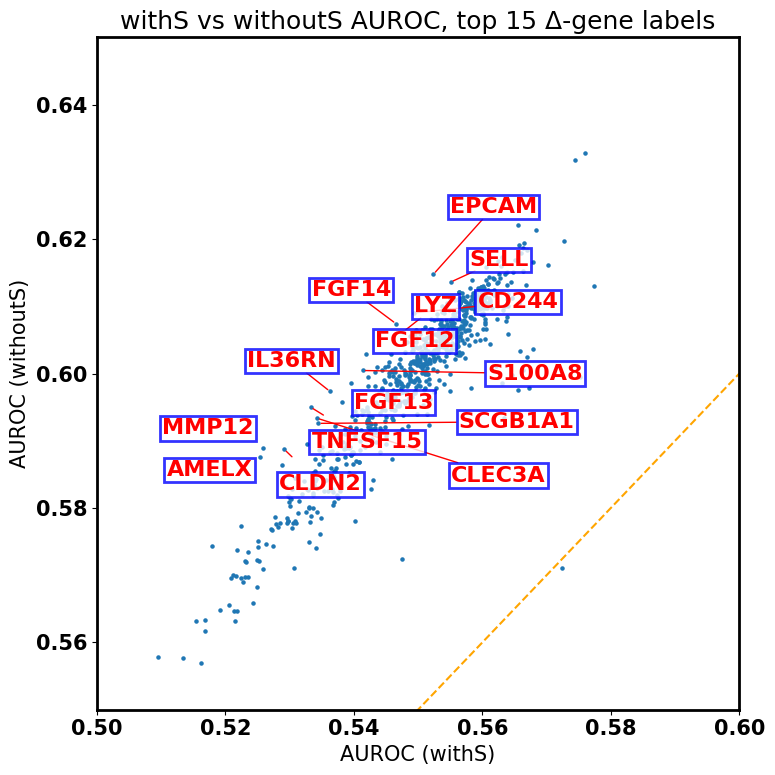

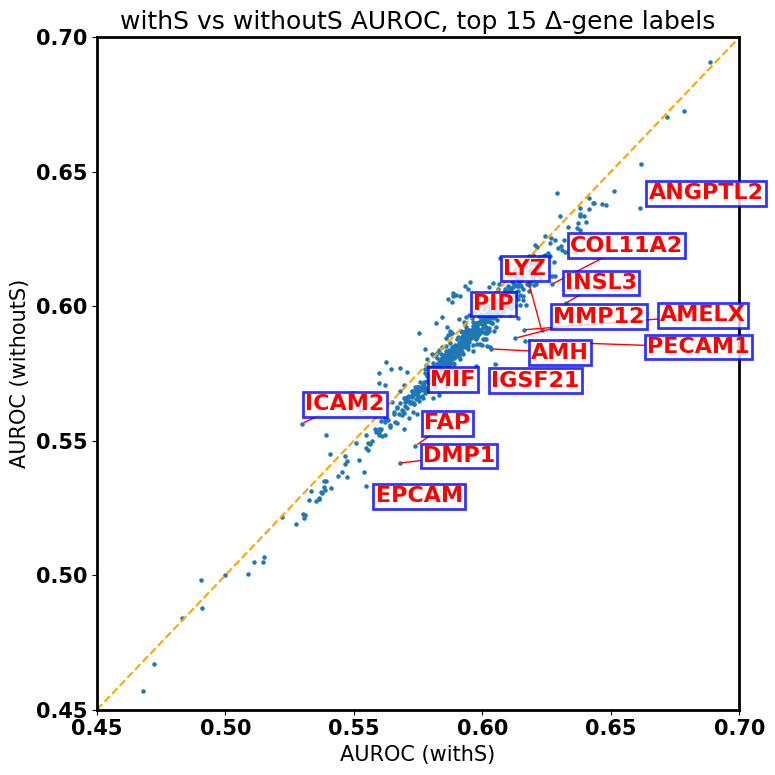

In [60]:
plt.rcParams.update({'font.size': 15, 'font.weight': 'heavy','axes.linewidth':2,'figure.figsize':[8,8]})
ligand_csv_files_withscn = glob.glob(os.path.join(wd, "withSCENIC\*.csv"))
celltype_names = [os.path.splitext(os.path.basename(npath))[0].replace('_ligand_activities','') for npath in ligand_csv_files_withscn]
for i, npath in enumerate(ligand_csv_files_withscn):
    target_genes_df_withscn = pd.read_csv(npath, sep=",")
    alt_path = npath.replace('withSCENIC','withoutSCENIC')
    target_genes_df_withoutscn = pd.read_csv(alt_path, sep=",")

    target_genes_withscn = target_genes_df_withscn[target_genes_df_withscn['auroc']>0.5]["test_ligand"]
    target_genes_withoutscn = target_genes_df_withoutscn[target_genes_df_withoutscn['auroc']>0.5]["test_ligand"]
    
    target_genes_df_withscn['test_ligand']   = target_genes_df_withscn['test_ligand'].astype(str)
    target_genes_df_withoutscn['test_ligand'] = target_genes_df_withoutscn['test_ligand'].astype(str)
    merged = pd.merge(
        target_genes_df_withscn,
        target_genes_df_withoutscn,
        on='test_ligand',
        how='outer',
        suffixes=('_withS', '_withoutS')
    )
    merged.index = merged['test_ligand']
    del merged['test_ligand']
    merged[merged<0] = 0

    # 1. pull out your two columns
    x = merged['auroc_withS']
    y = merged['auroc_withoutS']

    # 2. compute absolute differences and pick the top 15 genes
    diff  = (x - y).abs()
    top15 = diff.nlargest(15).index

    # 3. make the scatter + x=y dash line
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(x, y, s =5)

    # dashed x=y line spanning your 0.4–1.0 range
    xlims = [[0.5,0.6],[0.45, 0.7]]
    ylims = [[0.55,0.65],[0.45, 0.7]]
    ax.plot(xlims[i], xlims[i], color="orange", linestyle="--")

    # 4. annotate the 15 biggest outliers, collecting the Text objects
    texts = []
    for gene in top15:
        xi = x.loc[gene]
        yi = y.loc[gene]
        txt = ax.text(
            xi, yi, gene,
            size=16,
            color='r',
            weight='bold',
            bbox=dict(
                boxstyle="Square,pad=0.1",
                fc="white",
                ec="b",
                lw=2,
                alpha=0.8
            )
        )
        texts.append(txt)

    # 5. adjust to reduce overlaps, with red arrows
    adjust_text(
        texts,
        ax=ax,
        arrowprops=dict(arrowstyle='-', color='red')
    )

    # 6. polish axes
    ax.set_xlim(xlims[i])
    ax.set_ylim(ylims[i])
    ax.set_xlabel('AUROC (withS)')
    ax.set_ylabel('AUROC (withoutS)')
    ax.set_title('withS vs withoutS AUROC, top 15 Δ-gene labels')

    plt.tight_layout()
    # plt.show()

    plt.tight_layout()
    plt.savefig('vis/'+celltype_names[i]+' compare with no SCENIC_scatter.jpg',dpi = 300)


## Calculate enrichment (aurc)

In [5]:
epi_count = pd.read_csv('epi_count.csv',index_col = 0)

In [6]:
epi_count

,MIR1302-2HG,AL627309.1,AL627309.3,AL627309.4,AL732372.1,AC114498.1,AL669831.2,AL669831.5,FAM87B,LINC00115,...,AC007325.1,AC007325.4,AC007325.2,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,FAM231C
cell type,,,,,,,,,,,,,,,,,,,,,
MSI-H_Normal,0.0,0.004357,0.0,0.0,0.0,0.0,0.0,0.080077,0.002678,0.054648,...,0.0,0.009017,0.002674,0.053665,0.0,0.160790,0.000000,0.000000,0.177410,0.0
MSI-H_iCMS3,0.0,0.005149,0.0,0.0,0.0,0.0,0.0,0.075689,0.000000,0.055076,...,0.0,0.030365,0.072906,0.016075,0.0,0.148267,0.000000,0.000000,0.041721,0.0
MSS_Normal,0.0,0.005066,0.0,0.0,0.0,0.0,0.0,0.048506,0.000000,0.078752,...,0.0,0.004936,0.006254,0.025123,0.0,0.096176,0.001758,0.002823,0.052432,0.0
MSS_iCMS2,0.0,0.004217,0.0,0.0,0.0,0.0,0.0,0.049592,0.000000,0.044709,...,0.0,0.033170,0.008468,0.014582,0.0,0.190346,0.001377,0.000000,0.032556,0.0
MSS_iCMS3,0.0,0.003888,0.0,0.0,0.0,0.0,0.0,0.049023,0.000000,0.034921,...,0.0,0.045898,0.018671,0.012991,0.0,0.035743,0.000000,0.000000,0.030840,0.0


In [7]:
non_epi_count = pd.read_csv('non_epi_count.csv',index_col = 0)

In [8]:
non_epi_count

,MIR1302-2HG,OR4F5,AL627309.1,AL627309.3,AL627309.4,AL732372.1,AC114498.1,AL669831.2,AL669831.5,FAM87B,...,AC007325.1,AC007325.4,AC007325.2,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1
cell type,,,,,,,,,,,,,,,,,,,,,
MSI-H_B,0.0,0.0,0.002725,0.0,0.0,0.0,0.0,0.0,0.030816,0.000000,...,0.0,0.000000,0.000000,0.004428,0.0,0.008456,0.034442,0.007769,0.006546,0.0
MSI-H_Endothelial,0.0,0.0,0.001113,0.0,0.0,0.0,0.0,0.0,0.009735,0.000000,...,0.0,0.006427,0.001714,0.005856,0.0,0.007804,0.001333,0.000000,0.015366,0.0
MSI-H_Entericglial,0.0,0.0,0.002051,0.0,0.0,0.0,0.0,0.0,0.043223,0.000000,...,0.0,0.012352,0.000000,0.008932,0.0,0.000000,0.000000,0.000000,0.008475,0.0
MSI-H_Fibroblast,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.014781,0.001574,...,0.0,0.005228,0.000000,0.005432,0.0,0.008608,0.001190,0.000000,0.015332,0.0
MSI-H_Mast,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.024195,0.000000,...,0.0,0.002060,0.000000,0.002989,0.0,0.009889,0.000000,0.000000,0.016096,0.0
MSI-H_McDC,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.010753,0.000000,...,0.0,0.003005,0.000000,0.003924,0.0,0.012573,0.003239,0.000000,0.009954,0.0
MSI-H_Neutrophils,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.004191,0.000000,0.004680,0.000000,0.0
MSI-H_PlasmaB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.007032,0.000000,...,0.0,0.001670,0.000000,0.001053,0.0,0.003233,0.116516,0.088384,0.000000,0.0
MSI-H_T_NK,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.015902,0.000000,...,0.0,0.001638,0.000000,0.003700,0.0,0.007964,0.003692,0.000000,0.001895,0.0


### Obtain the averaged profile - epithelial

In [14]:
# load liver data from GEO - just go download it!
epi_data = sc.read_h5ad(r"F:\gdT_aim2\organized_data\CRC_reference\epithelial.h5ad")

In [ ]:
sc.pp.normalize_total(epi_data, key_added = 'normalization_factors')
sc.pp.log1p(epi_data)

View of AnnData object with n_obs × n_vars = 44458 × 33287
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample.ID', 'patient.ID', 'sample.origin', 'dataset', 'cell.type', 'iCMS', 'msi', 'normalization_factors'
    uns: 'log1p'

In [18]:
epi_data = epi_data[~epi_data.obs['sample.origin'].isin(['LymphNode','Normal'])]
epi_data_df = epi_data.to_df()
annotation_epi = epi_data.obs

In [19]:
annotation_epi.groupby('sample.origin')['msi'].apply(set)

sample.origin
Tumor      {MSI-H, MSS}
Tumor-2    {MSI-H, MSS}
Name: msi, dtype: object

In [20]:
epi_data_df['cell type']= annotation_epi['msi'].astype(str).map(str) + '_' + annotation_epi['iCMS'].astype(str).map(str)

In [21]:
epi_count = epi_data_df.groupby(['cell type']).mean().unstack().unstack().T
epi_count = epi_count.iloc[:,list((epi_count == 0).all(axis = 0) == 0)]

In [22]:
epi_count

,MIR1302-2HG,AL627309.1,AL627309.3,AL627309.4,AL732372.1,AC114498.1,AL669831.2,AL669831.5,FAM87B,LINC00115,...,AC007325.1,AC007325.4,AC007325.2,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,FAM231C
cell type,,,,,,,,,,,,,,,,,,,,,
MSI-H_Normal,0.000000,0.004357,0.000000,0.000000,0.000000,0.000000,0.000000,0.080077,0.002678,0.054648,...,0.000000,0.009017,0.002674,0.053665,0.000000,0.160790,0.000000,0.000000,0.177410,0.000000
MSI-H_iCMS3,0.000000,0.005149,0.000580,0.000000,0.000054,0.000000,0.000179,0.075689,0.000245,0.055076,...,0.000000,0.030365,0.072906,0.016075,0.000000,0.148267,0.000929,0.000327,0.041721,0.000038
MSS_Normal,0.000000,0.005066,0.000000,0.000000,0.000000,0.000000,0.000000,0.048506,0.000284,0.078752,...,0.000253,0.004936,0.006254,0.025123,0.000000,0.096176,0.001758,0.002823,0.052432,0.000000
MSS_iCMS2,0.000114,0.004217,0.000197,0.000033,0.000000,0.000018,0.000021,0.049592,0.000048,0.044709,...,0.000000,0.033170,0.008468,0.014582,0.000046,0.190346,0.001377,0.000798,0.032556,0.000015
MSS_iCMS3,0.000274,0.003888,0.000478,0.000000,0.000098,0.000000,0.000066,0.049023,0.000456,0.034921,...,0.000126,0.045898,0.018671,0.012991,0.000000,0.035743,0.000741,0.000374,0.030840,0.000057


In [23]:
epi_count[epi_count<0.001] = 0

In [24]:
epi_count.to_csv('epi_count.csv')

### Obtain the averaged profile - non-epithelial

In [5]:
# load liver data from GEO - just go download it!
non_epi_data = sc.read_h5ad(r"F:\gdT_aim2\organized_data\CRC_reference\nonepithelial.h5ad")
# non_epi_data_df = non_epi_data.to_df()
annotation_nonepi = non_epi_data.obs

In [6]:
non_epi_data = non_epi_data[~non_epi_data.obs['sample.origin'].isin(['LymphNode','Normal'])]
non_epi_data_df = non_epi_data.to_df()
# non_epi_data_df.max().max()

In [7]:
non_epi_data_df['cell type']= annotation_nonepi['MSS/MSI'].astype(str).map(str) + '_' + annotation_nonepi['cell.type'].astype(str).map(str)

In [8]:
non_epi_count = non_epi_data_df.groupby(['cell type']).mean().unstack().unstack().T
non_epi_count = non_epi_count.iloc[:,list((non_epi_count == 0).all(axis = 0) == 0)]

In [9]:
non_epi_count

,MIR1302-2HG,OR4F5,AL627309.1,AL627309.3,AL627309.4,AL732372.1,AC114498.1,AL669831.2,AL669831.5,FAM87B,...,AC007325.1,AC007325.4,AC007325.2,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1
cell type,,,,,,,,,,,,,,,,,,,,,
MSI-H_B,0.000000,0.000000,0.002725,0.000318,0.000000,0.000000,0.000000,0.000000,0.030816,0.000000,...,0.000000,0.000965,0.000000,0.004428,0.000000,0.008456,0.034442,0.007769,0.006546,0.000000
MSI-H_Endothelial,0.000000,0.000000,0.001113,0.000797,0.000000,0.000000,0.000000,0.000000,0.009735,0.000105,...,0.000000,0.006427,0.001714,0.005856,0.000000,0.007804,0.001333,0.000000,0.015366,0.000000
MSI-H_Entericglial,0.000000,0.000000,0.002051,0.000000,0.000000,0.000000,0.000000,0.000000,0.043223,0.000000,...,0.000000,0.012352,0.000000,0.008932,0.000000,0.000000,0.000000,0.000000,0.008475,0.000000
MSI-H_Fibroblast,0.000000,0.000000,0.000791,0.000000,0.000000,0.000000,0.000000,0.000000,0.014781,0.001574,...,0.000104,0.005228,0.000093,0.005432,0.000055,0.008608,0.001190,0.000164,0.015332,0.000000
MSI-H_Mast,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024195,0.000000,...,0.000000,0.002060,0.000000,0.002989,0.000000,0.009889,0.000000,0.000000,0.016096,0.000000
MSI-H_McDC,0.000000,0.000000,0.000517,0.000068,0.000000,0.000139,0.000000,0.000000,0.010753,0.000763,...,0.000160,0.003005,0.000233,0.003924,0.000000,0.012573,0.003239,0.000447,0.009954,0.000000
MSI-H_Neutrophils,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.004191,0.000000,0.004680,0.000000,0.000000
MSI-H_PlasmaB,0.000000,0.000000,0.000361,0.000052,0.000018,0.000021,0.000000,0.000000,0.007032,0.000055,...,0.000000,0.001670,0.000052,0.001053,0.000000,0.003233,0.116516,0.088384,0.000340,0.000000
MSI-H_T_NK,0.000043,0.000000,0.000530,0.000000,0.000000,0.000000,0.000000,0.000000,0.015902,0.000114,...,0.000000,0.001638,0.000195,0.003700,0.000000,0.007964,0.003692,0.000771,0.001895,0.000000


In [10]:
non_epi_count[non_epi_count<0.001] = 0

In [11]:
non_epi_count.to_csv('non_epi_count.csv')

### Visualize

In [9]:
nichenet_paths = [r"withSCENIC\TRM2Teff_ligand_activities_cancer_only.csv",
                  r"withSCENIC\Teff2Tex_ligand_activities_cancer_only.csv"]

enrichment = pd.DataFrame(index=epi_count.index, columns=nichenet_paths)
curves = pd.DataFrame(index=epi_count.index, columns=nichenet_paths)
for npath in nichenet_paths:
    nn_result = pd.read_csv(npath)
    target_genes = nn_result[nn_result['auroc']>0.5]['test_ligand'][0:min(30, nn_result[nn_result['auroc']>0.5].shape[0])]
    for i in range(epi_count.shape[0]):
        test_profile = pd.Series(epi_count.iloc[i, :], index=epi_count.columns).to_dict()
        auc_value, recovery_curve = compute_recovery_auc(test_profile, target_genes)
        curves[npath][i] = recovery_curve
        enrichment[npath][i] = auc_value

columns_vis = ['TRM2Teff','Teff2Tex']

enrichment = enrichment.astype('float')
enrichment.columns = columns_vis
curves.columns = columns_vis
enrichment.to_csv('epi_enrichment.csv')
# curves.to_csv('curves.csv')

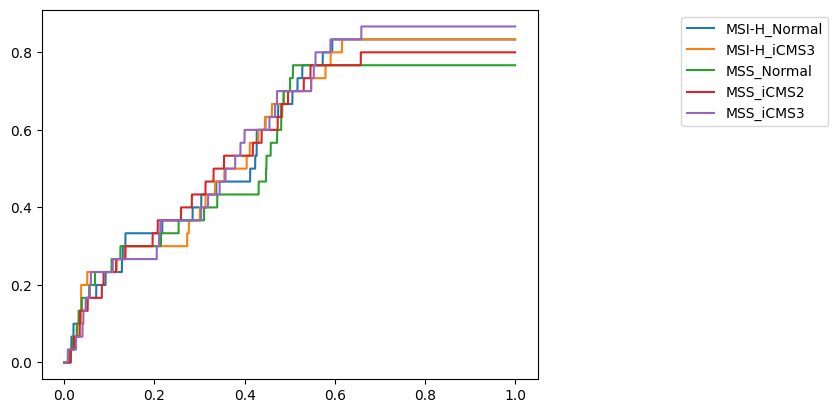

In [10]:
for j in range(0, curves.shape[1]):
    plt.close()
    for i in curves.index:#enrichment.index: #keep_curves:

        current_curve = curves.loc[i,:][j]
        x_vals = np.arange(1, len(current_curve) + 1) / len(current_curve)
        y_vals = np.array(current_curve)

        plt.plot(x_vals,y_vals, label = i)
        plt.legend(bbox_to_anchor= [1.6, 1], loc = 'upper right')


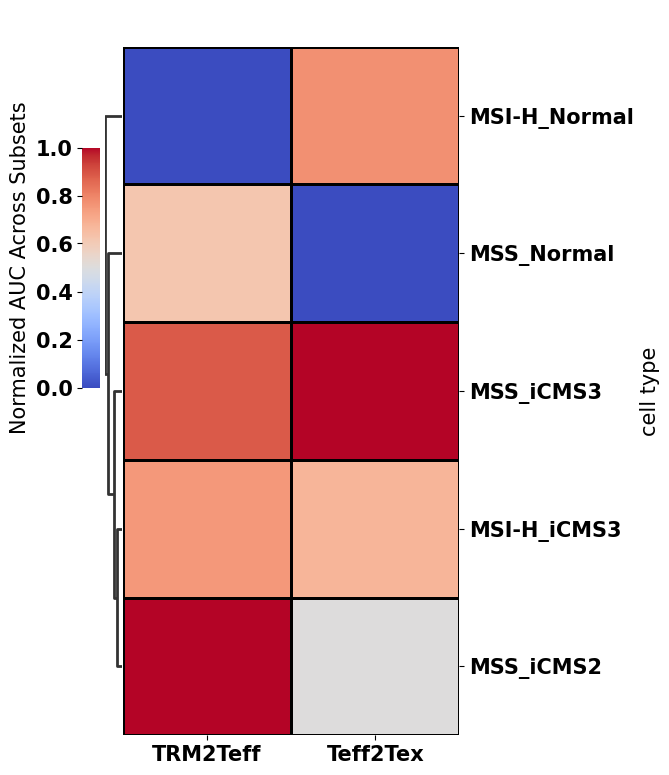

In [11]:
%matplotlib inline
plt.rcParams.update({'font.size': 15, 'font.weight': 'heavy','axes.linewidth':2})
#plt.rcParams.update(plt.rcParamsDefault)
kwargs = {'cmap': 'coolwarm'}
enrichment_norm = (enrichment-enrichment.min())/(enrichment.max()-enrichment.min()+0.000001)
clustergrid = sns.clustermap(enrichment_norm,figsize = (6,8),linewidths=2,vmin = 0, vmax = 1,
               linecolor = 'k',dendrogram_ratio = 0.05, colors_ratio = 0.5,
               row_cluster = True,col_cluster = False,cbar_kws={'label': 'Normalized AUC Across Subsets','location':"left"},
               **kwargs)
for a in clustergrid.ax_row_dendrogram.collections:
        a.set_linewidth(2)
clustergrid.ax_cbar.set_position([0, 0.5, 0.03, 0.3])

axs = clustergrid.fig.get_axes()
for j in range(0,len(axs)): 
    axs[j].set_xlabel('')

# plt.savefig('epi_ligand_auc.png',dpi = 300,bbox_inches='tight')

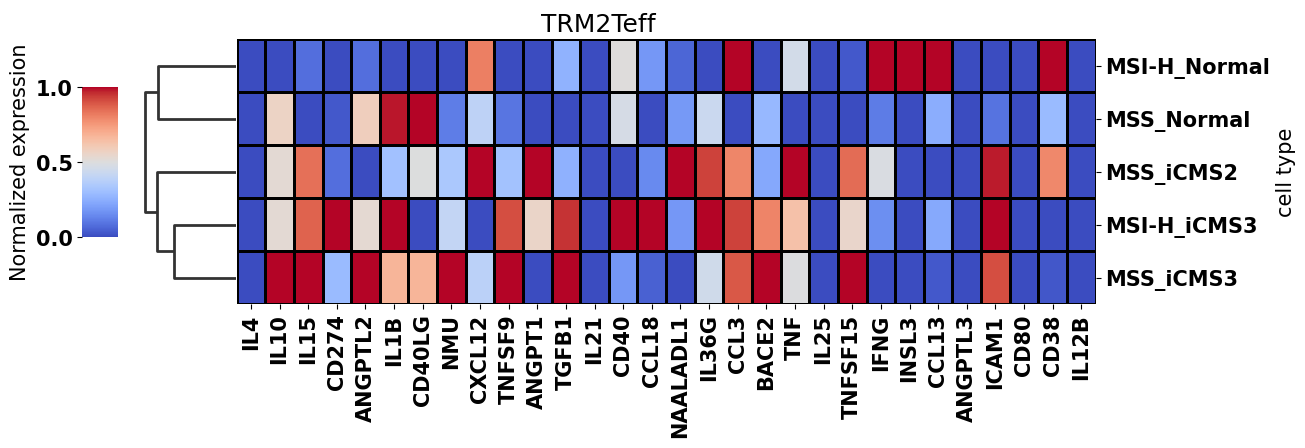

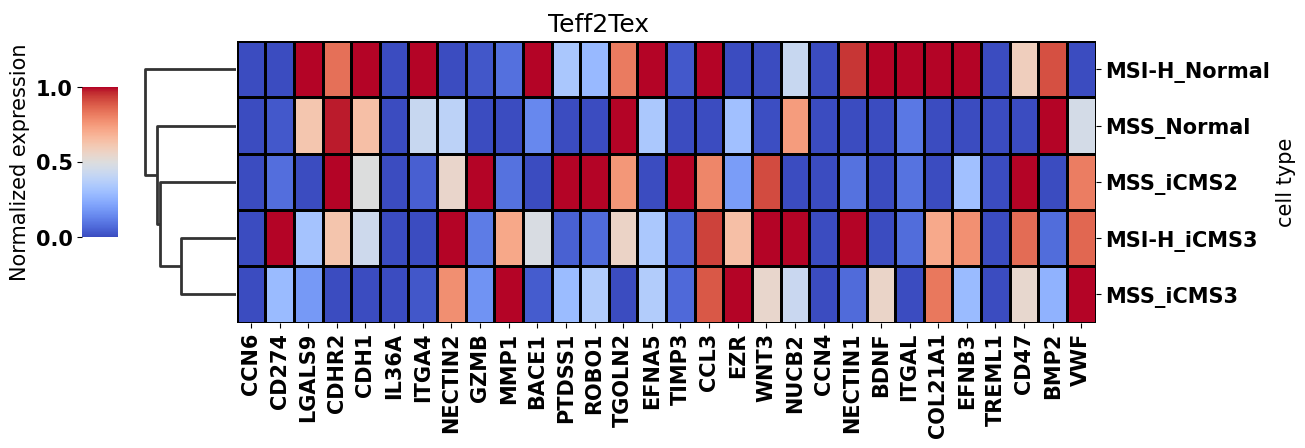

In [12]:
%matplotlib inline
alternative_names = ['TRM2Teff','Teff2Tex']
plt.rcParams.update({'font.size': 15, 'font.weight': 'heavy','axes.linewidth':2})
#plt.rcParams.update(plt.rcParamsDefault)
kwargs = {'cmap': 'coolwarm'}
nichenet_paths = [r"withSCENIC\TRM2Teff_ligand_activities_cancer_only.csv",
                  r"withSCENIC\Teff2Tex_ligand_activities_cancer_only.csv"]

for i, col in enumerate(nichenet_paths):
    nn_result = pd.read_csv(col)
    target_genes = nn_result[nn_result['auroc']>0.5]['test_ligand'][0:min(30, nn_result[nn_result['auroc']>0.5].shape[0])]

    heatmap_gut_df = epi_count.reindex(columns = target_genes.dropna(), fill_value=0)
    heatmap_gut_df_norm = (heatmap_gut_df-heatmap_gut_df.min())/(heatmap_gut_df.max()-heatmap_gut_df.min()+0.000001)
    clustergrid = sns.clustermap(heatmap_gut_df_norm,figsize = (12,5),linewidths=2,
                   linecolor = 'k',dendrogram_ratio = 0.1, colors_ratio = 0.5,vmin = 0, vmax = 1,
                   row_cluster = True,col_cluster = False,cbar_kws={'label': 'Normalized expression','location':"left"},
                   **kwargs)
    for a in clustergrid.ax_row_dendrogram.collections:
            a.set_linewidth(2)
    clustergrid.ax_cbar.set_position([-0.03, 0.5, 0.03, 0.3])

    axs = clustergrid.fig.get_axes()
    for j in range(0,len(axs)): 
        axs[j].set_xlabel('')
    clustergrid.fig.suptitle(alternative_names[i], x= 0.4, y = 0.95, ha='center')
    # plt.savefig(alternative_names[i]+'_T_heat.png',dpi = 300,bbox_inches='tight')

In [14]:
nichenet_paths = [r"withSCENIC\TRM2Teff_ligand_activities_cancer_only.csv",
                  r"withSCENIC\Teff2Tex_ligand_activities_cancer_only.csv"]

enrichment = pd.DataFrame(index=non_epi_count.index, columns=nichenet_paths)
curves = pd.DataFrame(index=non_epi_count.index, columns=nichenet_paths)
for npath in nichenet_paths:
    nn_result = pd.read_csv(npath)
    target_genes = nn_result[nn_result['auroc']>0.5]['test_ligand'][0:min(30, nn_result[nn_result['auroc']>0.5].shape[0])]
    for i in range(non_epi_count.shape[0]):
        test_profile = pd.Series(non_epi_count.iloc[i, :], index=non_epi_count.columns).to_dict()
        auc_value, recovery_curve = compute_recovery_auc(test_profile, target_genes)
        curves[npath][i] = recovery_curve
        enrichment[npath][i] = auc_value

columns_vis = ['TRM2Teff','Teff2Tex']

enrichment = enrichment.astype('float')
enrichment.columns = columns_vis
curves.columns = columns_vis
enrichment.to_csv('nonepi_enrichment.csv')
# curves.to_csv('curves.csv')

In [15]:
enrichment

,TRM2Teff,Teff2Tex
cell type,,
MSI-H_B,0.467027,0.490876
MSI-H_Endothelial,0.445575,0.577801
MSI-H_Entericglial,0.416571,0.572616
MSI-H_Fibroblast,0.520056,0.645492
MSI-H_Mast,0.489679,0.554728
MSI-H_McDC,0.597897,0.579712
MSI-H_Neutrophils,0.391435,0.474441
MSI-H_PlasmaB,0.367655,0.429664
MSI-H_T_NK,0.564557,0.500012


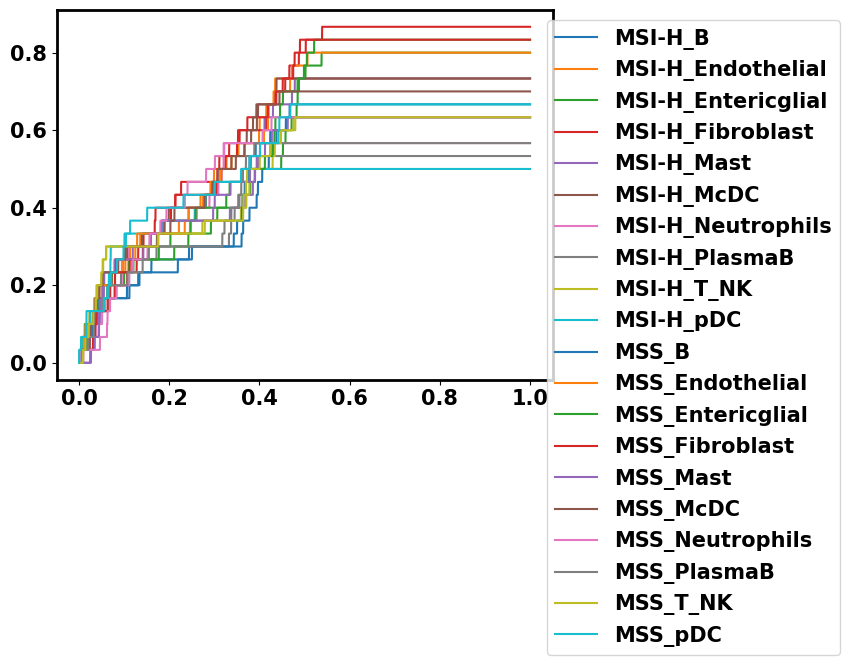

In [16]:
for j in range(0, curves.shape[1]):
    plt.close()
    for i in curves.index:#enrichment.index: #keep_curves:

        current_curve = curves.loc[i,:][j]
        x_vals = np.arange(1, len(current_curve) + 1) / len(current_curve)
        y_vals = np.array(current_curve)

        plt.plot(x_vals,y_vals, label = i)
        plt.legend(bbox_to_anchor= [1.6, 1], loc = 'upper right')

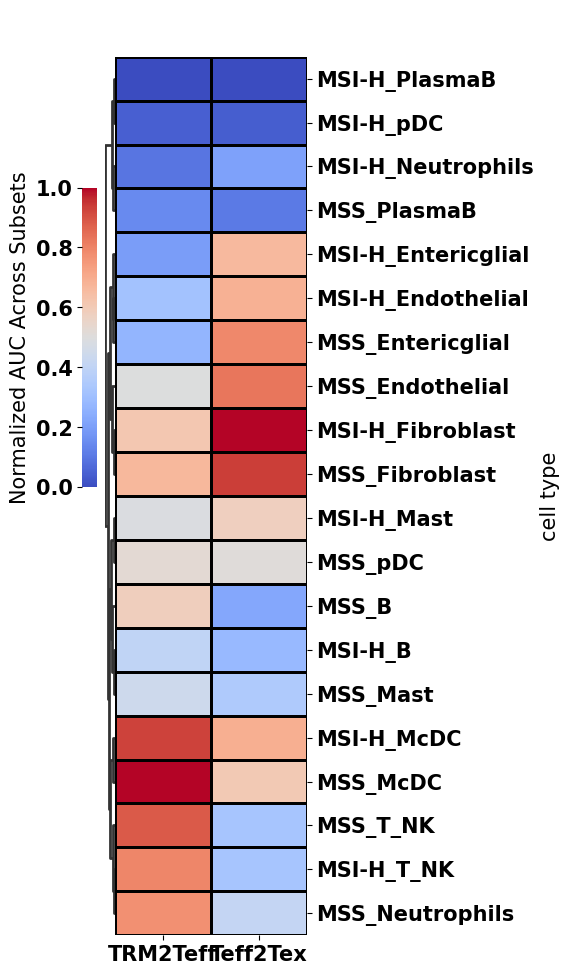

In [18]:
%matplotlib inline
plt.rcParams.update({'font.size': 15, 'font.weight': 'heavy','axes.linewidth':2})
#plt.rcParams.update(plt.rcParamsDefault)
kwargs = {'cmap': 'coolwarm'}
enrichment_norm = (enrichment-enrichment.min())/(enrichment.max()-enrichment.min()+0.000001)
clustergrid = sns.clustermap(enrichment_norm,figsize = (5,10),linewidths=2,vmin = 0, vmax = 1,
               linecolor = 'k',dendrogram_ratio = 0.05, colors_ratio = 0.5,
               row_cluster = True,col_cluster = False,cbar_kws={'label': 'Normalized AUC Across Subsets','location':"left"},
               **kwargs)
for a in clustergrid.ax_row_dendrogram.collections:
        a.set_linewidth(2)
clustergrid.ax_cbar.set_position([0, 0.5, 0.03, 0.3])

axs = clustergrid.fig.get_axes()
for j in range(0,len(axs)): 
    axs[j].set_xlabel('')

# plt.savefig('epi_ligand_auc.png',dpi = 300,bbox_inches='tight')

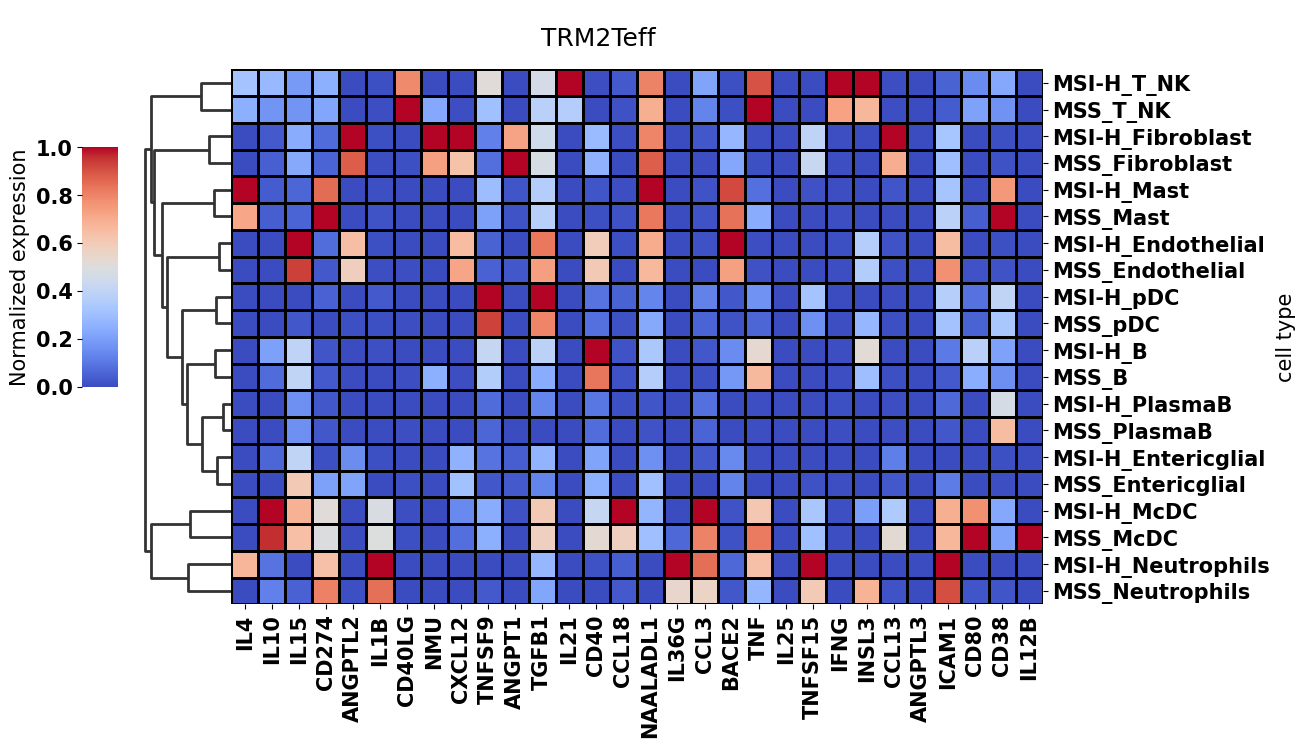

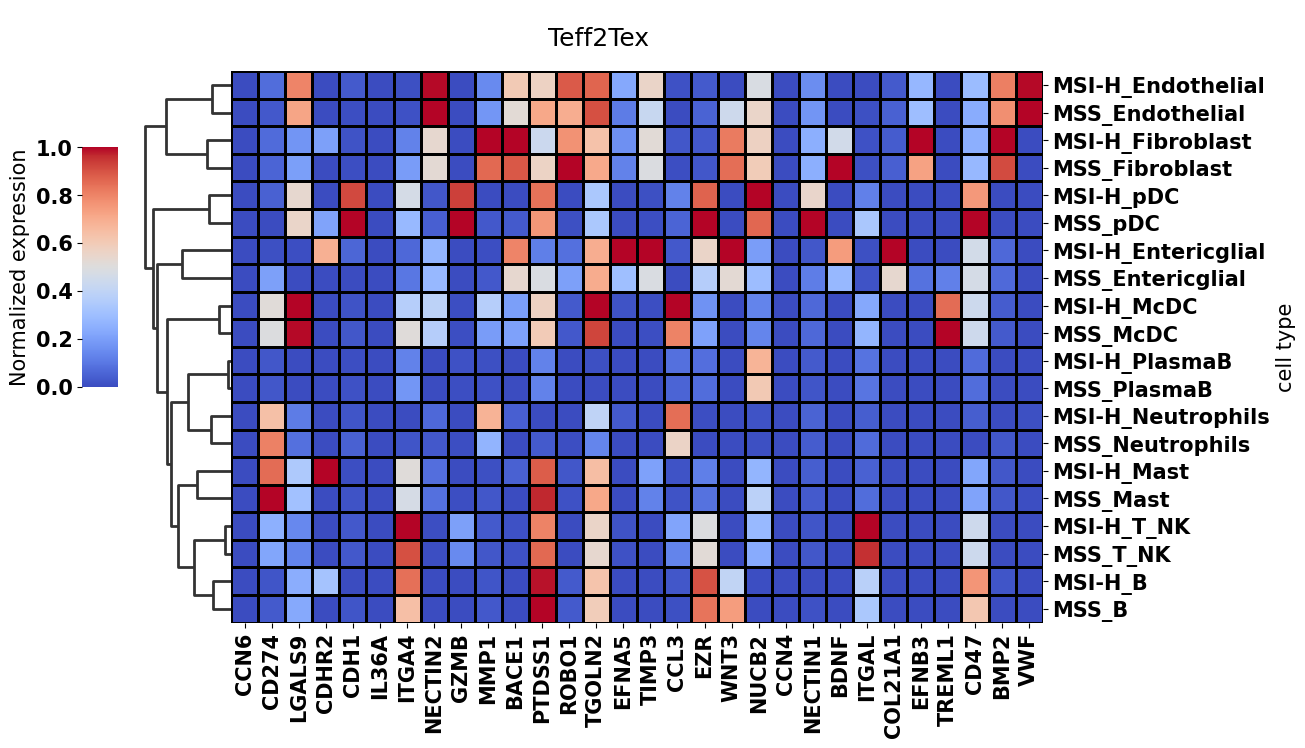

In [20]:
%matplotlib inline
alternative_names = ['TRM2Teff','Teff2Tex']
plt.rcParams.update({'font.size': 15, 'font.weight': 'heavy','axes.linewidth':2})
#plt.rcParams.update(plt.rcParamsDefault)
kwargs = {'cmap': 'coolwarm'}
nichenet_paths = [r"withSCENIC\TRM2Teff_ligand_activities_cancer_only.csv",
                  r"withSCENIC\Teff2Tex_ligand_activities_cancer_only.csv"]

for i, col in enumerate(nichenet_paths):
    nn_result = pd.read_csv(col)
    target_genes = nn_result[nn_result['auroc']>0.5]['test_ligand'][0:min(30, nn_result[nn_result['auroc']>0.5].shape[0])]

    heatmap_gut_df = non_epi_count.reindex(columns = target_genes.dropna(), fill_value=0)
    heatmap_gut_df_norm = (heatmap_gut_df-heatmap_gut_df.min())/(heatmap_gut_df.max()-heatmap_gut_df.min()+0.000001)
    clustergrid = sns.clustermap(heatmap_gut_df_norm,figsize = (12,8),linewidths=2,
                   linecolor = 'k',dendrogram_ratio = 0.1, colors_ratio = 0.5,vmin = 0, vmax = 1,
                   row_cluster = True,col_cluster = False,cbar_kws={'label': 'Normalized expression','location':"left"},
                   **kwargs)
    for a in clustergrid.ax_row_dendrogram.collections:
            a.set_linewidth(2)
    clustergrid.ax_cbar.set_position([-0.03, 0.5, 0.03, 0.3])

    axs = clustergrid.fig.get_axes()
    for j in range(0,len(axs)): 
        axs[j].set_xlabel('')
    clustergrid.fig.suptitle(alternative_names[i], x= 0.4, y = 0.95, ha='center')
    # plt.savefig(alternative_names[i]+'_T_heat.png',dpi = 300,bbox_inches='tight')